In [4]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import os

# =========================
# 最小化したい関数と勾配
# =========================

def function_2(x):
    return x[0] ** 2 + x[1] ** 2

def gradient_function_2(x):
    return np.array([2 * x[0], 2 * x[1]])

# =========================
# 勾配降下法（履歴付き）
# =========================

def gradient_descent(f, grad_f, init_x, lr=0.1, step_num=30):
    x = init_x.copy()
    x_history = [x.copy()]
    for _ in range(step_num):
        grad = grad_f(x)
        x -= lr * grad
        x_history.append(x.copy())
    return np.array(x_history)

# =========================
# 学習過程の取得
# =========================

init_x = np.array([-3.0, 4.0])
x_history = gradient_descent(function_2, gradient_function_2, init_x)

# =========================
# 損失関数の地形を生成
# =========================

x0 = np.linspace(-4, 4, 100)
x1 = np.linspace(-4, 4, 100)
X0, X1 = np.meshgrid(x0, x1)
Z = X0**2 + X1**2

# 勾配降下の軌跡
xs = x_history[:, 0]
ys = x_history[:, 1]
zs = np.array([function_2(np.array([x, y])) for x, y in zip(xs, ys)])

# =========================
# 複数視点の描画・保存
# =========================

view_angles = [(30, 30), (120, 30), (210, 30), (300, 30)]
image_paths = []

save_dir = "./views"
os.makedirs(save_dir, exist_ok=True)

for i, (azim, elev) in enumerate(view_angles):
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(X0, X1, Z, cmap="viridis", alpha=0.6, edgecolor="none")
    ax.plot(xs, ys, zs, marker="o", color="red", label="Gradient Descent Path")
    ax.set_xlabel("x0")
    ax.set_ylabel("x1")
    ax.set_zlabel("f(x0,x1)")
    ax.set_title(f"azim={azim}, elev={elev}")
    ax.view_init(elev=elev, azim=azim)
    save_path = os.path.join(save_dir, f"view_{i}.png")
    plt.savefig(save_path)
    image_paths.append(save_path)
    plt.close()

# =========================
# 画像を横に連結・保存
# =========================

images = [Image.open(p) for p in image_paths]
widths, heights = zip(*(img.size for img in images))
total_width = sum(widths)
max_height = max(heights)
combined_image = Image.new("RGB", (total_width, max_height))

x_offset = 0
for img in images:
    combined_image.paste(img, (x_offset, 0))
    x_offset += img.width

output_path = "combined_gradient_descent_views.png"
combined_image.save(output_path)

# =========================
# 画像の表示
# =========================

combined_image.show()
print(f"✅ 保存完了: {output_path}")

✅ 保存完了: combined_gradient_descent_views.png


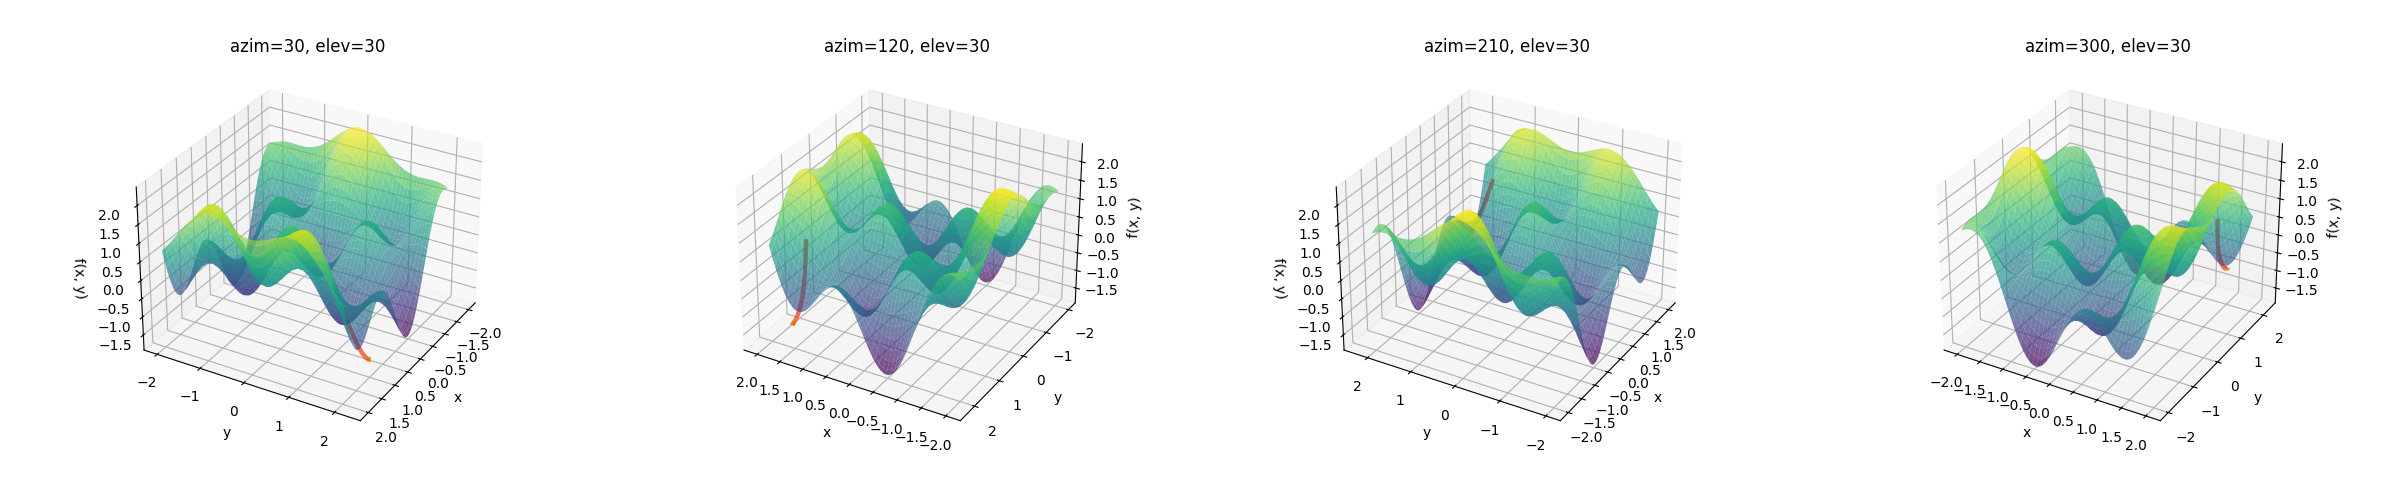

✅ 彩度変化付きの画像を保存: combined_saddle_descent_views_colored.png


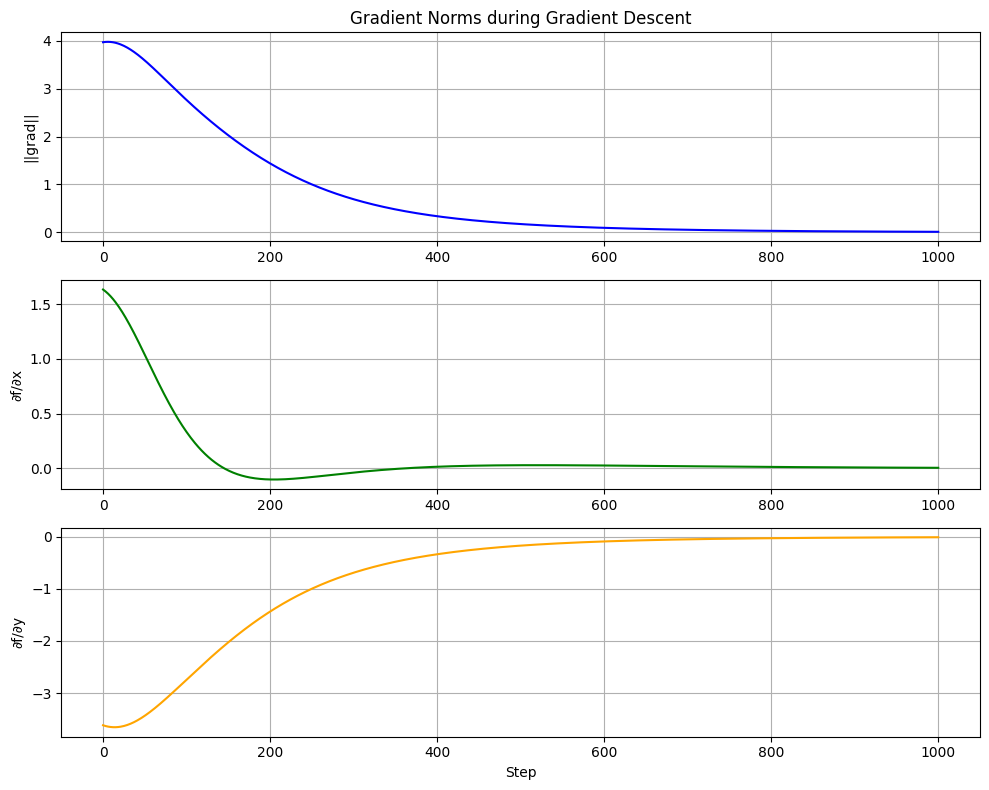

✅ 勾配の推移プロットを保存: gradient_values_plot.png


In [13]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from PIL import Image
import os

from IPython.display import display


# =========================
# 非凸関数とその勾配
# =========================
def complex_function(x):
    x0, x1 = x
    return np.sin(3 * x0) * np.cos(3 * x1) + 0.5 * x0**2 - 0.25 * x1**2


def complex_gradient(x):
    x0, x1 = x
    dx = 3 * np.cos(3 * x0) * np.cos(3 * x1) + x0
    dy = -3 * np.sin(3 * x0) * np.sin(3 * x1) - 0.5 * x1
    return np.array([dx, dy])


# =========================
# 勾配降下法（履歴付き）
# =========================
def gradient_descent(f, grad_f, init_x, lr=0.001, step_num=1000, tolerance=1e-3):
    x = init_x.copy()
    x_history = [x.copy()]
    for i in range(step_num):
        grad = grad_f(x)
        grad_norm = np.linalg.norm(grad)

        if grad_norm < tolerance:
            print(f"✅ 収束: ステップ {i} で勾配ノルム {grad_norm:.4e}")
            break

        x -= lr * grad
        if np.any(np.abs(x) > 1e6):  # 発散防止
            print(f"⚠️ 発散検出: ステップ {i} で x = {x}")
            break

        x_history.append(x.copy())
    return np.array(x_history)


# =========================
# 実行と地形データ生成
# =========================
init_x = np.array([1.5, 1.5])
x_history = gradient_descent(
    complex_function, complex_gradient, init_x, lr=0.001, step_num=1000, tolerance=1e-3
)
x0 = np.linspace(-2, 2, 100)
x1 = np.linspace(-2, 2, 100)
X0, X1 = np.meshgrid(x0, x1)
Z = np.sin(3 * X0) * np.cos(3 * X1) + 0.5 * X0**2 - 0.25 * X1**2

xs = x_history[:, 0]
ys = x_history[:, 1]
zs = np.array([complex_function(np.array([x, y])) for x, y in zip(xs, ys)])

# =========================
# 複数視点の描画・保存（色を時間に応じて変える）
# =========================
from matplotlib import cm
from matplotlib.colors import Normalize

view_angles = [(30, 30), (120, 30), (210, 30), (300, 30)]
image_paths = []

save_dir = "./saddle_views"
os.makedirs(save_dir, exist_ok=True)

# 軌跡の線分と色の準備
points = np.array([xs, ys, zs]).T.reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
norm = Normalize(0, len(segments))
colors = cm.autumn(norm(np.arange(len(segments))))

for i, (azim, elev) in enumerate(view_angles):
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(X0, X1, Z, cmap="viridis", alpha=0.7, edgecolor="none")

    # グラデーション付きの軌跡を描画
    lc = Line3DCollection(segments, colors=colors, linewidths=3)
    ax.add_collection3d(lc)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("f(x, y)")
    ax.set_title(f"azim={azim}, elev={elev}")
    ax.view_init(elev=elev, azim=azim)

    img_path = os.path.join(save_dir, f"saddle_view_{i}.png")
    plt.savefig(img_path)
    image_paths.append(img_path)
    plt.close()

# =========================
# 横連結して保存・Notebook表示
# =========================
images = [Image.open(p) for p in image_paths]
widths, heights = zip(*(img.size for img in images))
total_width = sum(widths)
max_height = max(heights)
combined_img = Image.new("RGB", (total_width, max_height))

x_offset = 0
for img in images:
    combined_img.paste(img, (x_offset, 0))
    x_offset += img.width

output_path = "combined_saddle_descent_views_colored.png"
combined_img.save(output_path)

display(combined_img)
print(f"✅ 彩度変化付きの画像を保存: {output_path}")

# =========================
# 勾配の変化も可視化（収束確認用）
# =========================
grads = np.array([complex_gradient(np.array([x, y])) for x, y in zip(xs, ys)])
grad_norms = np.linalg.norm(grads, axis=1)
grads_x = grads[:, 0]
grads_y = grads[:, 1]
steps = np.arange(len(grad_norms))

plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
plt.plot(steps, grad_norms, label="||grad||", color="blue")
plt.ylabel("||grad||")
plt.title("Gradient Norms during Gradient Descent")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(steps, grads_x, label="∂f/∂x", color="green")
plt.ylabel("∂f/∂x")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(steps, grads_y, label="∂f/∂y", color="orange")
plt.xlabel("Step")
plt.ylabel("∂f/∂y")
plt.grid(True)

plt.tight_layout()
plt.savefig("gradient_values_plot.png")
plt.show()

print("✅ 勾配の推移プロットを保存: gradient_values_plot.png")

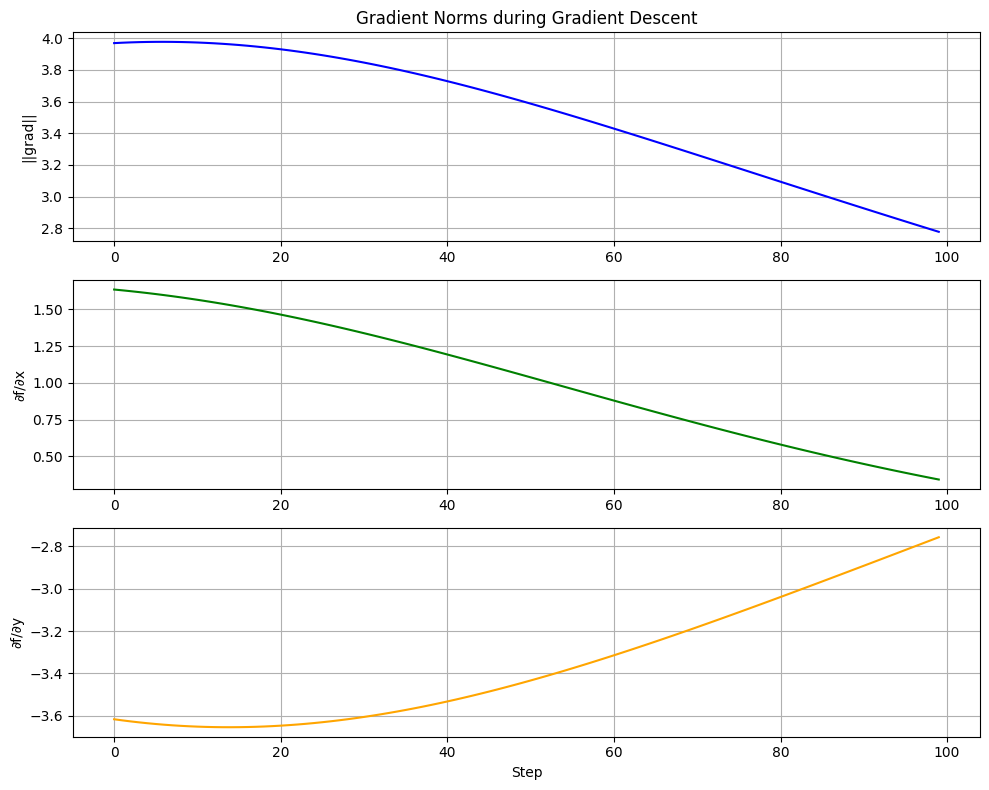

✅ 勾配の推移プロットを保存: gradient_values_plot.png


In [11]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


# =========================
# 非凸関数とその勾配
# =========================
def complex_function(x):
    x0, x1 = x
    return np.sin(3 * x0) * np.cos(3 * x1) + 0.5 * x0**2 - 0.25 * x1**2


def complex_gradient(x):
    x0, x1 = x
    dx = 3 * np.cos(3 * x0) * np.cos(3 * x1) + x0
    dy = -3 * np.sin(3 * x0) * np.sin(3 * x1) - 0.5 * x1
    return np.array([dx, dy])


# =========================
# 勾配降下法（履歴付き）
# =========================
def gradient_descent(f, grad_f, init_x, lr=0.001, step_num=100):
    x = init_x.copy()
    x_history = [x.copy()]
    grad_norms = []
    grads_x = []
    grads_y = []

    for i in range(step_num):
        grad = grad_f(x)
        grad_norms.append(np.linalg.norm(grad))
        grads_x.append(grad[0])
        grads_y.append(grad[1])
        x -= lr * grad
        if np.any(np.abs(x) > 1e6):  # 発散防止
            print(f"⚠️ 発散検出: ステップ {i} で x = {x}")
            break
        x_history.append(x.copy())

    return np.array(x_history), grad_norms, grads_x, grads_y


# =========================
# 実行
# =========================
init_x = np.array([1.5, 1.5])
x_history, grad_norms, grads_x, grads_y = gradient_descent(
    complex_function, complex_gradient, init_x, lr=0.001, step_num=100
)

# =========================
# プロット
# =========================
steps = np.arange(len(grad_norms))

plt.figure(figsize=(10, 8))

# 勾配ノルムの変化
plt.subplot(3, 1, 1)
plt.plot(steps, grad_norms, label="||grad||", color="blue")
plt.ylabel("||grad||")
plt.title("Gradient Norms during Gradient Descent")
plt.grid(True)

# x方向の勾配
plt.subplot(3, 1, 2)
plt.plot(steps, grads_x, label="∂f/∂x", color="green")
plt.ylabel("∂f/∂x")
plt.grid(True)

# y方向の勾配
plt.subplot(3, 1, 3)
plt.plot(steps, grads_y, label="∂f/∂y", color="orange")
plt.xlabel("Step")
plt.ylabel("∂f/∂y")
plt.grid(True)

plt.tight_layout()
plt.savefig("gradient_values_plot.png")
plt.show()
print("✅ 勾配の推移プロットを保存: gradient_values_plot.png")